In [1]:
from nltk.corpus import movie_reviews
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

In [2]:
def get_data():
    """
    获取影评数据
    """
    dataset = []
    y_labels = []
    # 遍历类别
    for cat in movie_reviews.categories():
        # 遍历每个类目的评论id
        for fileid in movie_reviews.fileids(cat):
            # 读取评论词语列表
            words = list(movie_reviews.words(fileid))
            dataset.append(u' '.join(words))
            cat_label = 1 if cat == "pos" else 0
            y_labels.append(cat_label)
    return dataset, y_labels

In [3]:
# 加载数据
input_dataset, y_labels = get_data()
# 划分数据为训练集和测试集 
x_train, x_test, y_train, y_test = train_test_split(input_dataset, y_labels, random_state=42)
# 向量化
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
feats = X_train.shape[1] # 特征数量
print("特征数量=", X_train.shape[1])
print("训练集实例数量=", X_train.shape[0])
X_test = vectorizer.transform(x_test)
print("测试集实例数量=", X_test.shape[0])

特征数量= 35393
训练集实例数量= 1500
测试集实例数量= 500


In [4]:
# 最大迭代次数
training_steps = 101

# 构建适用Theano的训练验证集
D = (X_train.A, np.array(y_train))
D_dev = [X_test.A, np.array(y_test)]

# 声明Theano符号变量x表示训练数据矩阵
x = T.dmatrix("x")
# 声明Theano符号变量y表示标记向量
y = T.dvector("y")

rng = np.random
# 随机初始化权值向量w，它为共享变量，在训练过程中可更新
w = theano.shared(rng.randn(feats), name="w")
# 随机初始化偏置变量b，它为共享变量，在训练过程中可更新
b = theano.shared(0., name="b")

# 创建Theano表达式图
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))       # 预测为1的概率
prediction = p_1 > 0.5                        # 预测概率>0.5预测为True，否则预测为False
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # 二元交叉熵损失，xent的形状取决于输入的类别标记y
cost = xent.mean() + 0.01 * (w ** 2).sum()    # 损失值 = 平均每个实例的交叉熵损失 + 模型的L2正则化罚项
gw, gb = T.grad(cost, [w, b])                 # 计算损失关于w,b的梯度
                             
# 编译训练函数
train = theano.function(
          inputs=[x,y],
          outputs=[prediction, cost],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))

# 编译预测函数
predict = theano.function(
          inputs=[x,y], 
          outputs=[prediction, cost])

# 训练
epoch_li = []
cost_li = []
cost_li_dev = []
for i in range(training_steps):
    pred, cost = train(D[0], D[1])
    epoch_li.append(i)
    cost_li.append(cost)
    pred, cost_dev = predict(D_dev[0], D_dev[1])
    cost_li_dev.append(cost_dev)
    print("epoch %d " % i, "cost=%f" % cost, "validation cost %f" % cost_dev)

epoch 0  cost=353.077452 validation cost 351.646169
epoch 1  cost=351.666965 validation cost 350.241761
epoch 2  cost=350.262214 validation cost 348.843054
epoch 3  cost=348.863171 validation cost 347.450021
epoch 4  cost=347.469810 validation cost 346.062635
epoch 5  cost=346.082103 validation cost 344.680869
epoch 6  cost=344.700024 validation cost 343.304698
epoch 7  cost=343.323546 validation cost 341.934096
epoch 8  cost=341.952645 validation cost 340.569037
epoch 9  cost=340.587293 validation cost 339.209496
epoch 10  cost=339.227466 validation cost 337.855447
epoch 11  cost=337.873138 validation cost 336.506865
epoch 12  cost=336.524283 validation cost 335.163727
epoch 13  cost=335.180879 validation cost 333.826007
epoch 14  cost=333.842898 validation cost 332.493682
epoch 15  cost=332.510318 validation cost 331.166727
epoch 16  cost=331.183114 validation cost 329.845118
epoch 17  cost=329.861263 validation cost 328.528833
epoch 18  cost=328.544740 validation cost 327.217847
epo

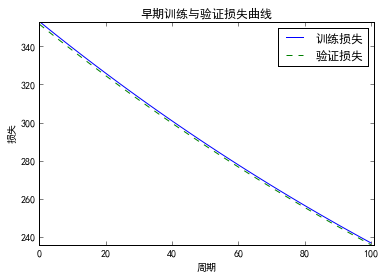

In [5]:
%matplotlib inline
# 画训练损失曲线，验证损失曲线
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 设置横纵坐标轴范围
plt.xlim(0,101)
plt.ylim(min(cost_li[:101]+cost_li_dev[:101]), max(cost_li[:101]+cost_li_dev[:101]))
# 绘制训练损失曲线
plt.plot(epoch_li[:101], cost_li[:101], label='训练损失')
# 绘制验证损失曲线
plt.plot(epoch_li[:101], cost_li_dev[:101], label='验证损失', linestyle='--')
# 设置图像标题
plt.title('早期训练与验证损失曲线')
# 设置横坐标名称
plt.xlabel('周期')
# 设置纵坐标名称
plt.ylabel('损失')
# 绘制图例
plt.legend(loc='upper right')
# 显示
plt.show()